### Imports and connection to CAT

In [33]:
!pip install ufal.udpipe
!pip install conllu

In [34]:
import mysql.connector
import os
import pandas as pd
import codecs
import math
import pylab
import statistics
import re
import collections
import numpy as np
import ufal.udpipe
from matplotlib import mlab
from collections import Counter
from statistics import *
from nltk import sent_tokenize
from conllu import parse

In [35]:
cnx = mysql.connector.connect(user="user1", password="qwerty", host='localhost', database='cat',
                              auth_plugin='mysql_native_password')

cursor = cnx.cursor(buffered=True)

### Preprocessing

In [4]:
vowels = ["а", "я", "о", "ё", "у", "ю", "е", "э", "ы", "и", "á", "ó"]

In [29]:
def deletePunctuation(corpus_df):

    '''Function deletes rows with punctuation at `word` column of a given Pandas Dataset.
    Requires a dataset with a column named `word` as input.
    Returns cleaned dataset with reset indexes.
    
    Future work: make a column name with punctuation a required data.'''

    one_letter = corpus_df[corpus_df.word.str.contains('\W+')]
    rubbish = set(list(one_letter.word) + list('!~№č`@#$；%^¼&*�‑§()€_…<-©≥>+–↔=→−\|?:•;,—/.[×]{}̆≈"‒﹐（），．：；？')) - set('1234567890qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNMЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁйцукенгшщзхъфывапролджэячсмитьбюё')
    cleaned = corpus_df.loc[~corpus_df['word'].isin(rubbish)]
    return cleaned.reset_index(drop=True)

In [30]:
def prepareFunctionWordsList():

    '''Takes no arguments, reads .txt files from the local repository.
    Returns a list with all the function words from the files except for the "part" and "pronom" ones from oneWordTrash.txt.
    
    Future work: make the function download .txt files from github repository.'''
    
    adv = codecs.open( "adv.txt", "r", "utf_8_sig" ).readlines()
    adv = [line.rstrip() for line in adv]
    conj = codecs.open( "conj.txt", "r", "utf_8_sig" ).readlines()
    conj = [line.rstrip() for line in conj]
    interject = codecs.open( "interject.txt", "r", "utf_8_sig" ).readlines()
    interject = [line.rstrip() for line in interject]
    part = codecs.open( "part.txt", "r", "utf_8_sig" ).readlines()
    part = [line.rstrip() for line in part]
    prep = codecs.open( "prep.txt", "r", "utf_8_sig" ).readlines()
    prep = [line.rstrip() for line in prep]
    pronom = codecs.open( "pronom.txt", "r", "utf_8_sig" ).readlines()
    pronom = [line.rstrip() for line in pronom]

    oneWord = codecs.open( "oneWordTrash.txt", "r", "utf_8_sig" ).readlines()
    oneWord = [line.rstrip() for line in oneWord]
    pos = oneWord[2::6]
    freq = oneWord[3::6]
    oneWord = oneWord[1::6]
    
    words = pd.DataFrame({"word": oneWord, "pos": pos, "freq": freq})
    words = words[words.pos != "part"]
    words = words[words.pos != "intj"]
    oneWord = list(words.word) + prep + part + pronom + adv + conj + interject
    return oneWord

In [31]:
def UDparse(file):
    
    '''Takes filename and parses it via UDPipe.
    Returns sentences (strings) and tokens (lists of tuples with lemmas, tokens, POS tags and other data.
    
    Future work: '''
    
    model = "russian-syntagrus-ud-2.4-190531.udpipe"

    ud_model = ufal.udpipe.Model.load(model)
    pipe = ufal.udpipe.Pipeline(ud_model, "tokenize", "tag", "parse", "conllu")

    text = codecs.open(file, "r", "utf_8_sig")
    text = text.read()
    parsed = pipe.process(text)

    sentences = parse(parsed)
    tokens = []

    for sent in sentences:
        for token in sent:
            tokens.append(token)

    sentences = [s.metadata for s in sentences]
            
    return sentences, tokens

### Function words rate

#### CAT

In [7]:
words = ("SELECT id_sent, id_text, word FROM cat.words")
cursor.execute(words)
words = cursor.fetchall()

meta = ("SELECT id_text, id_domain FROM cat.metadata")
cursor.execute(meta)
meta = cursor.fetchall()

In [8]:
words_df = pd.DataFrame(words, columns = ['id_sent', 'id_text', 'word']) 
meta_df = pd.DataFrame(meta, columns = ['id_text', 'id_domain'])
words_df = pd.merge(words_df, meta_df, on=('id_text'), how ='left')

words_df.head()

,id_sent,id_text,word,id_domain
0,1,691,А.,2
1,1,691,В.,2
2,1,691,Малько,2
3,1,691,",",2
4,1,691,Я.,2


In [9]:
CAT = deletePunctuation(words_df)

In [10]:
funcWords = prepareFunctionWordsList()

In [17]:
def functionWordsRatePlot(lenTuples, domain):
    df = pd.DataFrame(lenTuples, columns =['len', 'percent']) 
    len_list = df.len.unique()
    len_dict = {}
    for length in len_list:
        sub = df[df.len == length]
        len_dict[length] = median(sub.percent)
    xlist = len_dict.keys()
    ylist = len_dict.values()

    pylab.bar(xlist, ylist)
    pylab.title('Function words rate, {0}'.format(domain), fontsize=15)
    pylab.xlabel('Sentence length', fontsize=12)
    pylab.ylabel('Function words rate', fontsize=12)
    pylab.show()

In [14]:
def countSentLen(df):
    sentdf = df[['id_sent', 'id_text']]
    result = [tuple(x) for x in sentdf.values]

    return Counter(result)

def countTrash(df):
    trashdf = df[df['word'].isin(funcWords)][['id_sent', 'id_text']]
    result = [tuple(x) for x in trashdf.values]

    return Counter(result)

In [19]:
def functionWordsRate(id_domain):
    trashTuples = countTrash(CAT[CAT['id_domain'] == id_domain])
    allWordsTuples = countSentLen(CAT[CAT['id_domain'] == id_domain])
    percents = []
    lenpercents = []

    for i in allWordsTuples:
        a = trashTuples[i] / allWordsTuples[i]
        percents.append(a)
        lenpercents.append((allWordsTuples[i], a))
    k = pd.DataFrame(lenpercents, columns=['len', 'percent'])
    ls = []

    for l in sorted(list(k.len.unique())):
        ls.append((l, median(list(k[k.len==l]['percent']))))

    print(median(percents))
    
    return lenpercents

0.16666666666666666


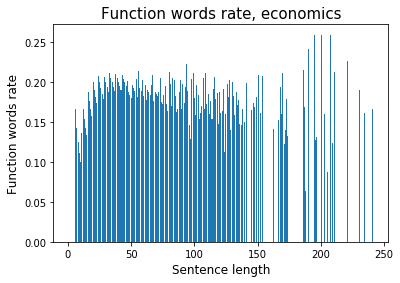

In [23]:
lens_econ = functionWordsRate(1) # economics

functionWordsRatePlot(lens_econ, 'economics')

0.13636363636363635


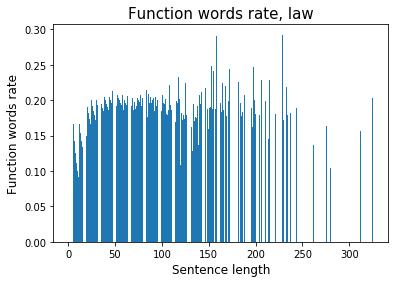

In [22]:
lens_law = functionWordsRate(2) # law

functionWordsRatePlot(lens_law, 'law')

0.16666666666666666


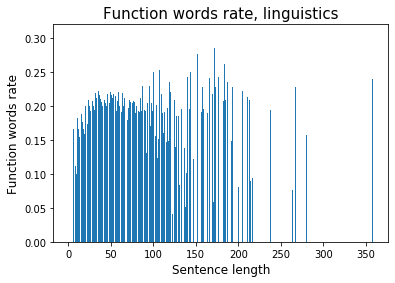

In [25]:
lens_ling = functionWordsRate(3) # ling

functionWordsRatePlot(lens_ling, 'linguistics')

0.16666666666666666


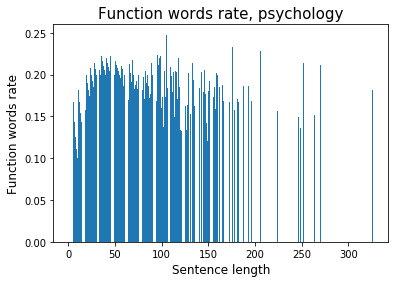

In [26]:
lens_ps = functionWordsRate(4) # psych

functionWordsRatePlot(lens_ps, 'psychology')

0.15789473684210525


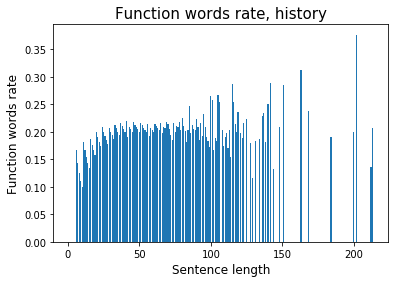

In [27]:
lens_h = functionWordsRate(5) # hist

functionWordsRatePlot(lens_h, 'history')

0.17391304347826086


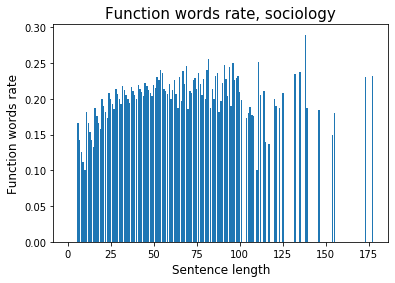

In [28]:
lens_soc = functionWordsRate(6) # soc

functionWordsRatePlot(lens_soc, 'sociology')

#### Котята

In [99]:
df = pd.DataFrame(lens_ling, columns =['len', 'percent']) 
list1 = df.len.unique()
dict1 = {}
for l in list1:
    sub = df[df.len == l]
    dict1[l] = median(sub.percent)

In [100]:
max(df[df.len == 5].percent)

0.8

In [101]:
def findTokensInSents(text):
    text = codecs.open(text, "r", "utf_8_sig" ).readlines()
    text = [line.rstrip() for line in text]
    text = re.sub('(\d.)+', '', " ".join(text))
    text = re.split('(?<![А-ЯЁA-Z])\s*[.?!]+\s*(?=[А-ЯЁA-Z\(])', text)

    tokens = []
    for t in text:
        tokens.append(re.findall('\w+', t.lower()))
    tokens = [t for t in tokens if t != []]
    return tokens

In [102]:
def countTrashPercentageKitten(sents):
    percents = []
    for s in sents:
        trash = [w for w in s if w in funcWords]
        percents.append(len(trash) / len(s))
        try:
            a = dict1[len(s)]
        except KeyError:
            a = 0.23
        if len(s) > 7 and len(trash)/len(s) > a*2:
            se = []
            for k in s:
                if k in trash:
                    se.append("++{0}++".format(k))
                else:
                    se.append(k)
            print (" ".join(se))
    return percents

In [103]:
tokensInText = findTokensInSents("studtext1.txt")
median(countTrashPercentageKitten(tokensInText))

можно сказать ++что++ дискурс определяет пишущего ++а++ ++не++ наоборот
эти манеры ++не++ личные ++или++ универсальные ++а++ меняются ++в++ исторических ++и++ социальных аспектах
++не++ ++только++ правящие ++или++ подчиненные группы ++но++ ++и++ другие группы имееют свои идеологии
человек который создает слова ++и++ предложения ++не++ ++только++ говорит ++или++ пишет ++но++ ++и++ делает ++что++ ++то++
интерес хомского обращен ++прежде++ ++всего++ ++на++ идеальный язык
++но++ лингвистической основой ++все++ ++еще++ служит языковая теория халлидея
++не++ понимают ++что++ ++и++ исследователь проводящий анализ ++не++ может быть нейтральным ++и++ описывать контекст ++как++ ++бы++ факты
++это++ может быть влияет ++на++ ++то++ ++о++ ++чем++ позволительно писать
текст ++или++ дискурс ++в++ телевидении радио ++или++ газете ++в++ котором сообщается ++о++ событиях
++все++ эти схемы ++не++ обязательно входят ++в++ одну новость ++но++ ++это++ возможно
++надо++ ++также++ обратить внимание ++на++ ++т

0.24

In [104]:
tokensInText = findTokensInSents("studtext2.txt")
median(countTrashPercentageKitten(tokensInText))

издание ++было++ переведено ++на++ финский язык ++в++ году
савиньон ++там++ ++же++ ++также++ выделяет термины competence ++и++ performance
++в++ этих теориях интересуются ++тем++ ++как++ люди используют язык
++также++ они делают упор ++на++ значение коммуникативности ++при++ обучении
++кроме++ этого население финляндии немногочисленно ++и++ ++из++ этого следует ++что++ материала исследования ++не++ ++так++ много ++как++ ++в++ странах ++с++ большим населением
++если++ ++в++ одном ++из++ них происходят изменения ++это++ влияет ++и++ ++на++ другие компоненты
они считают ++что++ речь идёт ++не++ ++о++ том нужна ++ли++ грамматика ++или++ ++нет++ ++а++ ++о++ том ++как++ её преподавать
ателье вышел первый ++раз++ ++в++ ++и++ годах ++и++ существует ++только++ ++в++ электронном виде
++во++ первые ++сколько++ учащиеся участвует ++в++ выполнении упражнении
++если++ ++в++ инструкциях ++было++ ++бы++ сказано расскажи своей паре тогда задание ++было++ ++бы++ классифицировано безусловно ++как++ пара


0.2222222222222222

### Long words rate

#### CAT

In [14]:
words = ("SELECT id_text, word FROM cat.words")
cursor.execute(words)
words = cursor.fetchall()

meta = ("SELECT id_text, id_domain FROM cat.metadata")
cursor.execute(meta)
meta = cursor.fetchall()

In [15]:
words_df = pd.DataFrame(words, columns = ['id_text', 'word']) 
meta_df = pd.DataFrame(meta, columns = ['id_text', 'id_domain'])
words_df = pd.merge(words_df, meta_df, on=('id_text'), how ='left')

words_df.head()

,id_text,word,id_domain
0,691,А.,2
1,691,В.,2
2,691,Малько,2
3,691,",",2
4,691,Я.,2


In [16]:
CAT = deletePunctuation(words_df)

In [20]:
def showDomainLenPlot(id_domain, domain_name):
    words = list(CAT.loc[CAT['id_domain'] == id_domain]['word'])
    lens = [len(set(word)) for word in words]

    counter = collections.Counter()
    for length in lens:
        counter[length] += 1
    for value in counter:
        counter[value] = counter[value] / len(lens) * 100
    data = dict(counter)
    xlist = []
    ylist = []
    for key in sorted(data.keys()):
        xlist.append(key)
        ylist.append(data[key])
    print('25 perc:', np.percentile(lens, 25), '\n50 perc:', np.percentile(lens, 50), '\n75 perc:', np.percentile(lens, 75))

    pylab.plot (xlist, ylist, marker="o")
    pylab.vlines(np.percentile(lens, 25), min(ylist), max(ylist), color = 'r')
    pylab.vlines(np.percentile(lens, 50), min(ylist), max(ylist), color = 'r')
    pylab.vlines(np.percentile(lens, 75), min(ylist), max(ylist), color = 'r')
    pylab.title('Word length distribution, {0}'.format(domain_name), fontsize=15)
    pylab.xlabel('Length', fontsize=12)
    pylab.ylabel('Percent', fontsize=12)
    pylab.show()

25 perc: 3.0 
50 perc: 6.0 
75 perc: 8.0


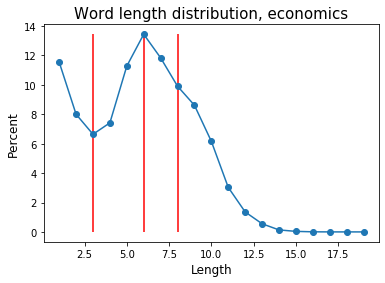

In [21]:
showDomainLenPlot(1, "economics") # economics

25 perc: 3.0 
50 perc: 6.0 
75 perc: 8.0


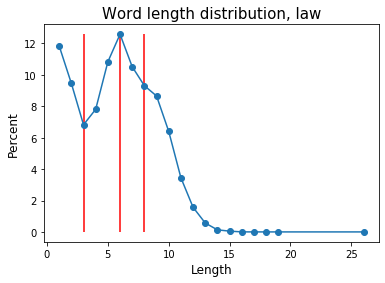

In [22]:
showDomainLenPlot(2, 'law')#law

25 perc: 3.0 
50 perc: 5.0 
75 perc: 7.0


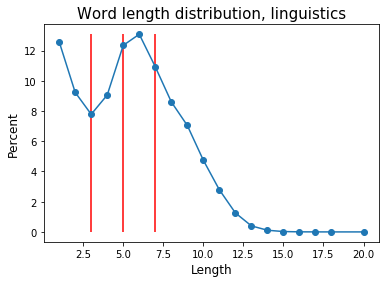

In [24]:
showDomainLenPlot(3, 'linguistics') #linguistics

25 perc: 3.0 
50 perc: 6.0 
75 perc: 8.0


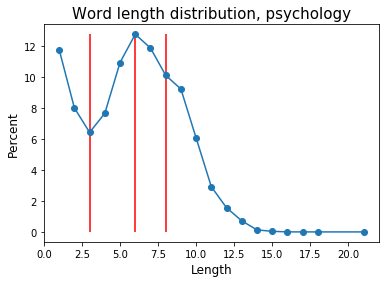

In [25]:
showDomainLenPlot(4, 'psychology')

25 perc: 3.0 
50 perc: 6.0 
75 perc: 8.0


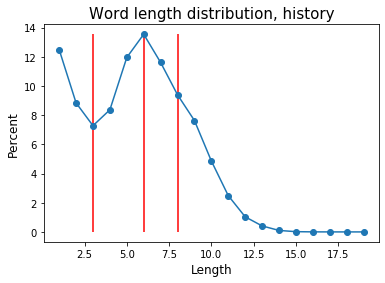

In [26]:
showDomainLenPlot(5, 'history')

25 perc: 3.0 
50 perc: 6.0 
75 perc: 8.0


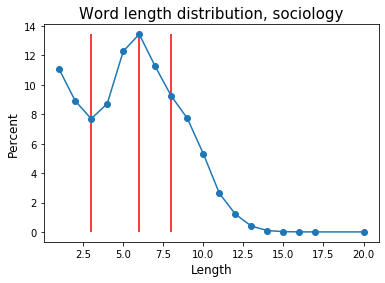

In [27]:
showDomainLenPlot(6, 'sociology')

#### Kittens

In [110]:
sent, tokens = UDparse('studtext1.txt')

In [111]:
tokens1 = pd.DataFrame(tokens)
tokens1.rename(columns={'form':'word'}, inplace=True)
tokens1 = deletePunctuation(tokens1)

In [112]:
tokens1 = list(tokens1.word)

In [65]:
def countLengths(tokens):
    counter = collections.Counter()
    lens = []
    for token in tokens:
        lens.append(len(token))
    for length in lens:
        counter[length] += 1
    for value in counter:
        counter[value] = counter[value] / len(lens) * 100
    return(counter)

In [66]:
def showLenPlot(tokens):
    data = dict(countLengths(tokens))
    xlist = []
    ylist = []
    for key in sorted(data.keys()):
        xlist.append(key)
        ylist.append(data[key])
    pylab.plot(xlist, ylist, marker="o")
    pylab.title('Word length distribution', fontsize=15)
    pylab.xlabel('Length', fontsize=12)
    pylab.ylabel('Percent', fontsize=12)
    pylab.show()

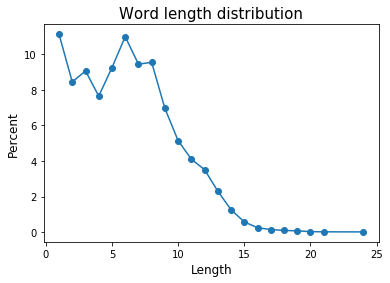

In [99]:
showLenPlot(tokens1) #linguistics

In [113]:
sent, tokens = UDparse('studtext2.txt')

In [114]:
tokens2 = pd.DataFrame(tokens)
tokens2.rename(columns={'form':'word'}, inplace=True)
tokens2 = deletePunctuation(tokens2)

In [115]:
tokens2 = list(tokens2.word)

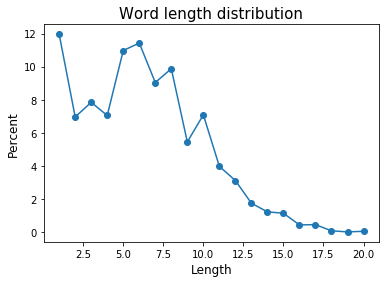

In [104]:
showLenPlot(tokens2) #linguistics

"Короткие" - слова длиной 1-4 буквы.

"Средняя длина" - 5-8 букв.

"Длинные" - слова длиной 9-35 букв.

Из фактов о том, что средняя медианная длина слова в русском языке составляет 3 буквы, а самое длинное слово - 35 буквы.
http://tverlingua.ru/archive/001/01_1-006.htm

In [105]:
def countLongPercentage(tokens):
    allTokens = len(tokens)
    counter = countLengths(tokens)
    totalLong = 0
    for length in range(9, 35):
        totalLong += counter[length]
    return totalLong/allTokens

In [106]:
def countShortPercentage(tokens):
    allTokens = len(tokens)
    counter = countLengths(tokens)
    totalShort = 0
    for length in range(1, 4):
        totalShort += counter[length]
    return totalShort/allTokens

In [116]:
print("text 1:", "long", countLongPercentage(tokens1), "; short", countShortPercentage(tokens1))
print("text 2:", "long", countLongPercentage(tokens2), "; short", countShortPercentage(tokens2))

text 1: long 0.0013473924646744291 ; short 0.0015823177451502282
text 2: long 0.001881913441188024 ; short 0.0020250464987776207


Сравним график домена лингвистики и графики студенческих текстов:

In [101]:
words = list(words_df.loc[words_df['id_domain'] == 3]['target']) #linguistics
lens = [len(set(word)) for word in words]

In [99]:
words_wo = list(CAT.loc[CAT['id_domain'] == 3]['target']) #linguistics
lens_wo = [len(set(word)) for word in words]

In [112]:
def CompareCatAndKittens(words, lens):
    counter_domain = collections.Counter()
    counter_stud1 = collections.Counter()
    counter_stud2 = collections.Counter()

    #domain
    for length in lens:
        counter_domain[length] += 1
    for value in counter_domain:
        counter_domain[value] = counter_domain[value] / len(lens) * 100
    data_domain = dict(counter_domain)
    xlist_domain = []
    ylist_domain = []
    for key in sorted(data_domain.keys()):
        xlist_domain.append(key)
        ylist_domain.append(data_domain[key])

    text1 = codecs.open("studtext1.txt", "r", "utf_8_sig").readlines()
    text1 = [line.rstrip() for line in text1]
    joinedText1 = " ".join(text1)
    tokens = re.findall('\w+', joinedText1.lower())
    data_stud1 = dict(countLengths(tokens))
    xlist_stud1 = []
    ylist_stud1 = []
    for key in sorted(data_stud1.keys()):
        xlist_stud1.append(key)
        ylist_stud1.append(data_stud1[key])

    text2 = codecs.open("studtext2.txt", "r", "utf_8_sig").readlines()
    text2 = [line.rstrip() for line in text2]
    joinedText2 = " ".join(text2)
    tokens = re.findall('\w+', joinedText2.lower())
    data_stud2 = dict(countLengths(tokens))
    xlist_stud2 = []
    ylist_stud2 = []
    for key in sorted(data_stud2.keys()):
        xlist_stud2.append(key)
        ylist_stud2.append(data_stud2[key])    

    pylab.plot (xlist_domain, ylist_domain, '-', label='domain')
    pylab.plot (xlist_stud1, ylist_stud1, '--', label='studtext1')
    pylab.plot (xlist_stud2, ylist_stud2, ':', label='studtext2')
    pylab.title('Word length distribution', fontsize=15)
    pylab.xlabel('Length', fontsize=12)
    pylab.ylabel('Percent', fontsize=12)
    pylab.show()

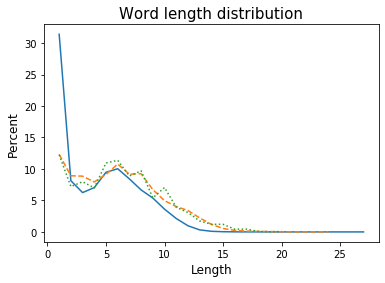

In [113]:
CompareCatAndKittens(words, lens) #котята без пунктуации, кот с пунктуацией

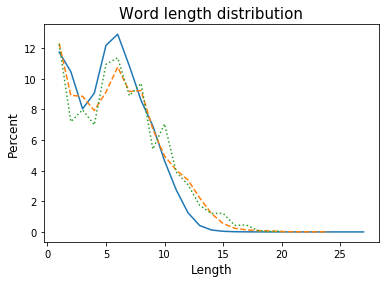

In [114]:
CompareCatAndKittens(words_wo, lens_wo) #котята без пунктуации, кот без пунктуации

Из двух графиков выше поняли что лучше всего убирать пунктуацию везде.

### Frequent words rate

#### CAT

In [117]:
unigramsFreq = ("""SELECT lemma, pos, sum(freq1), sum(freq2), sum(freq3), sum(freq4), sum(freq5), sum(freq6) FROM
	(SELECT u.id_unigram, u.unigram, l.lemma, p.pos, u.freq1, u.freq2, u.freq3, u.freq4, u.freq5, u.freq6 
    FROM cat.unigrams u, cat.lemmas l, cat.pos p 
    WHERE u.lemma = l.id_lemmas and p.id_pos = l.id_pos) AS newtable
GROUP BY lemma, pos""")
cursor.execute(unigramsFreq)
unigramsFreq = cursor.fetchall()

In [118]:
lemmas = pd.DataFrame(unigramsFreq, columns = ['lemma', 'POS', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
lemmas[:15]

,lemma,POS,f1,f2,f3,f4,f5,f6
0,доктринальный,ADJ,1,215,1,3,7,23
1,основной,ADJ,3508,2507,1760,2109,1809,896
2,Библиографический,ADJ,6,248,14,10,44,5
3,правовой,ADJ,490,12313,84,176,431,366
4,высший,ADJ,659,732,185,2885,790,299
5,важный,ADJ,1956,1420,1143,1883,1911,1231
6,современный,ADJ,1648,1958,1927,1562,1232,1064
7,юридический,ADJ,230,4362,122,89,269,377
8,правоприменительный,ADJ,6,398,5,0,2,4
9,самый,ADJ,1317,1068,1461,1232,1935,1490


In [3]:
lemmas[lemmas.lemma=="быт"]

,lemma,POS,f1,f2,f3,f4,f5,f6
26291,быт,ADJ,0,0,1,0,1,0
63660,быт,NOUN,11,38,70,20,275,33
298494,быт,VERB,0,0,4,0,1,0


Нормазизуем каждый доман по формуле x = (NUM * NORM) / DOMAIN SIZE

| domain_id | domain_name | domain_size |
|:----------|:------------|:------------|
|**1**|	Экономика | 2 494 422 |
|**2**|	Юриспруденция |  2 636 290 |
|**3**|	Лингвистика | 2 691 363 |
|**4**|	Педагогика и психология | 1 880 004 |
|**5**|	История | 2 808 313 |
|**6**|	Социология | 1 500 196 |

In [119]:
def ipm_CAT(df):
    df.f1 = df.f1.apply(lambda x: float((x*1000)/2494422))
    df.f2 = df.f2.apply(lambda x: float((x*1000)/2636290))
    df.f3 = df.f3.apply(lambda x: float((x*1000)/2691363))
    df.f4 = df.f4.apply(lambda x: float((x*1000)/1880004))
    df.f5 = df.f5.apply(lambda x: float((x*1000)/2808313))
    df.f6 = df.f6.apply(lambda x: float((x*1000)/1500196))
    return df

In [120]:
lemmas = ipm_CAT(lemmas)
lemmas[:15]

,lemma,POS,f1,f2,f3,f4,f5,f6
0,доктринальный,ADJ,0.000401,0.081554,0.000372,0.001596,0.002493,0.015331
1,основной,ADJ,1.406338,0.950958,0.653944,1.121806,0.644159,0.597255
2,Библиографический,ADJ,0.002405,0.094072,0.005202,0.005319,0.015668,0.003333
3,правовой,ADJ,0.196438,4.670579,0.031211,0.093617,0.153473,0.243968
4,высший,ADJ,0.264189,0.277663,0.068738,1.534571,0.281308,0.199307
5,важный,ADJ,0.784150,0.538636,0.424692,1.001594,0.680480,0.820559
6,современный,ADJ,0.660674,0.742710,0.715994,0.830849,0.438698,0.709241
7,юридический,ADJ,0.092206,1.654598,0.045330,0.047340,0.095787,0.251300
8,правоприменительный,ADJ,0.002405,0.150970,0.001858,0.000000,0.000712,0.002666
9,самый,ADJ,0.527978,0.405115,0.542848,0.655318,0.689026,0.993204


In [121]:
lemmas[lemmas.lemma=="учащийся"]

,lemma,POS,f1,f2,f3,f4,f5,f6
13295,учащийся,ADJ,0.001203,0.000000,0.002601,0.035638,0.002493,0.001333
79214,учащийся,NOUN,0.007617,0.000379,0.011147,0.838828,0.028487,0.001333
286131,учащийся,VERB,0.001203,0.000000,0.000000,0.035638,0.000712,0.001333


#### Kittens

In [131]:
def findTopFreq(df, N=50, domain='f3'):
    frequencies = Counter(zip(df.lemma, df.upos))
    st = pd.DataFrame(list(frequencies), columns=['lemma', 'POS'])
    st['f'] = frequencies.values()
    
    st = st[st.POS != 'PUNCT']
    st = st[st.POS != 'NUM']
    st = st[st.POS != 'X']
    st = st[st.POS != 'PROPN']
    st = st[st.f > 2]
    
    st.f = st.f.apply(lambda x: (x*1000)/len(st.lemma))
    
    merged = st.merge(lemmas[['lemma', 'POS', domain]], how='inner', on=["lemma", "POS"])
    merged['f-{0}'.format(domain)] = merged.f / merged.f3
    merged = merged.sort_values(by=['f-{0}'.format(domain)], ascending=False)
    
    return merged[:N]

In [130]:
sent1, tokens1 = UDparse('studtext1.txt')
st1_df = pd.DataFrame(tokens1)
findTopFreq(st1_df)

,lemma,POS,f,f3,f-f3
173,заинтересоваться,VERB,3.198294,0.000000,inf
643,новост,NOUN,3.198294,0.000000,inf
817,ракетный,ADJ,3.198294,0.000000,inf
860,спикер,NOUN,6.396588,0.000000,inf
488,отдалиться,VERB,3.198294,0.000000,inf
900,обезоруживать,VERB,3.198294,0.000000,inf
530,институтский,ADJ,4.264392,0.000000,inf
801,Североатлантический,ADJ,6.396588,0.000000,inf
760,Друзье,NOUN,3.198294,0.000000,inf
890,разряжеть,VERB,3.198294,0.000000,inf


In [132]:
sent2, tokens2 = UDparse('studtext2.txt')
st2_df = pd.DataFrame(tokens2)
findTopFreq(st2_df)

,lemma,POS,f,f3,f-f3
426,бихевиористский,ADJ,4.629630,0.000000,inf
602,страница,VERB,4.629630,0.000000,inf
595,упр.,NOUN,21.604938,0.000000,inf
378,самопознание,NOUN,4.629630,0.000000,inf
587,фотограф,NOUN,4.629630,0.000000,inf
446,учащемуся,VERB,4.629630,0.000000,inf
566,тренировать,VERB,4.629630,0.000000,inf
80,общеевропейский,ADJ,33.950617,0.000372,9.137344e+04
105,упражнение,NOUN,449.074074,0.006688,6.714563e+04
456,коммуникативность,NOUN,43.209877,0.000743,5.814673e+04


### Readability

ASL = words_num/sent_num - average sent length

ASW = syll_num/word_num - average num of syllables per word

FRE = 208.7 - 2.6 * ASL - 39.2 * ASW

FKG = 0.36 * ASL + 5.76 * ASW - 11.97

#### CAT

In [133]:
words = ("SELECT id_text, id_word FROM cat.words")
cursor.execute(words)
words = cursor.fetchall()

sent = ("SELECT id_text, id_sent FROM cat.words ORDER BY id_text")
cursor.execute(sent)
sent = cursor.fetchall()

syll = ("SELECT id_text, word FROM cat.words")
cursor.execute(syll)
syll = cursor.fetchall()

meta = ("SELECT id_text, id_domain FROM cat.metadata")
cursor.execute(meta)
meta = cursor.fetchall()

In [134]:
words_df = pd.DataFrame(words, columns = ['id_text', 'target']) 
meta_df = pd.DataFrame(meta, columns = ['id_text', 'id_domain'])
words_df = pd.merge(words_df, meta_df, on=('id_text'), how ='left')

sent_df = pd.DataFrame(sent, columns = ['id_text', 'target']) 
sent_df = pd.merge(sent_df, meta_df, on=('id_text'), how ='left')
sent_df_no_duplicates = sent_df.drop_duplicates()

syll_df = pd.DataFrame(syll, columns = ['id_text', 'target']) 
syll_df = pd.merge(syll_df, meta_df, on=('id_text'), how ='left')

In [4]:
economics = list(set(sent_df_no_duplicates[sent_df_no_duplicates['id_domain'] == 1]['id_text']))
law = list(set(sent_df_no_duplicates[sent_df_no_duplicates['id_domain'] == 2]['id_text']))
linguistics = list(set(sent_df_no_duplicates[sent_df_no_duplicates['id_domain'] == 3]['id_text']))
psychology = list(set(sent_df_no_duplicates[sent_df_no_duplicates['id_domain'] == 4]['id_text']))
history = list(set(sent_df_no_duplicates[sent_df_no_duplicates['id_domain'] == 5]['id_text']))
sociology = list(set(sent_df_no_duplicates[sent_df_no_duplicates['id_domain'] == 6]['id_text']))

domains = [economics, law, linguistics, psychology, history, sociology]

In [5]:
def select_domain(data, domain):
    selected_data = list(data.loc[data['id_domain'] == domain]['target'])

    return selected_data

In [7]:
def count_readability_for_text(text, words, sent, syll):
    words_num = words[words['id_text']==text].shape[0]
    sent_num = sent[sent['id_text']==text].shape[0]
    words = list(syll[syll['id_text']==text]['target'])

    syll_num = 0
    for word in words:
        for letter in set(word):
            if letter in vowels:
                syll_num += 1
    ASL = words_num/sent_num
    ASW = syll_num/words_num
    FKG = 0.36 * ASL + 5.76 * ASW - 11.97
    FRE = 208.7 - 2.6 * ASL - 39.2 * ASW
    
    return FKG, FRE

In [8]:
#readability по каждому тексту домена отдельно
def count_readability_for_domain(domain, words, sent, syll):
    FKG = []
    FRE = []
    for text in domain:
        result = count_readability_for_text(text, words, sent, syll)
        FKG.append(result[0])
        FRE.append(result[1])
    return FKG, FRE

In [112]:
FKG, FRE = count_readability_for_domain(economics, words_df, sent_df_no_duplicates, syll_df)
print('mean FKG:', statistics.mean(FKG), 'mean FRE:', statistics.mean(FRE))
print('median FKG:', statistics.median(FKG), 'median FRE:', statistics.median(FRE))

mean FKG: 7.112328137379111 mean FRE: 75.15042813710386
median FKG: 6.915209444087742 median FRE: 76.59868566904197


In [97]:
FKG, FRE = count_readability_for_domain(law, words_df, sent_df_no_duplicates, syll_df)
print('mean FKG:', statistics.mean(FKG), 'mean FRE:', statistics.mean(FRE))
print('median FKG:', statistics.median(FKG), 'median FRE:', statistics.median(FRE))

mean FKG: 5.7743320135946155 mean FRE: 84.61997300031643
median FKG: 5.409535963868111 median FRE: 87.02811443751477


In [94]:
FKG, FRE = count_readability_for_domain(linguistics, words_df, sent_df_no_duplicates, syll_df)
print('mean FKG:', statistics.mean(FKG), 'mean FRE:', statistics.mean(FRE))
print('median FKG:', statistics.median(FKG), 'median FRE:', statistics.median(FRE))

mean FKG: 6.191372354643496 mean FRE: 81.22718440779684
median FKG: 6.065657495460952 median FRE: 82.17210167902729


In [91]:
FKG, FRE = count_readability_for_domain(psychology, words_df, sent_df_no_duplicates, syll_df)
print('mean FKG:', statistics.mean(FKG), 'mean FRE:', statistics.mean(FRE))
print('median FKG:', statistics.median(FKG), 'median FRE:', statistics.median(FRE))

mean FKG: 6.945912612842746 mean FRE: 76.44790618888355
median FKG: 6.699336609336607 median FRE: 78.13250790638834


In [88]:
FKG, FRE = count_readability_for_domain(history, words_df, sent_df_no_duplicates, syll_df)
print('mean FKG:', statistics.mean(FKG), 'mean FRE:', statistics.mean(FRE))
print('median FKG:', statistics.median(FKG), 'median FRE:', statistics.median(FRE))

mean FKG: 4.940571373707879 mean FRE: 90.4139698589767
median FKG: 4.84131761442441 median FRE: 91.10684446993595


In [85]:
FKG, FRE = count_readability_for_domain(sociology, words_df, sent_df_no_duplicates, syll_df)
print('mean FKG:', statistics.mean(FKG), 'mean FRE:', statistics.mean(FRE))
print('median FKG:', statistics.median(FKG), 'median FRE:', statistics.median(FRE))

mean FKG: 6.774720941326222 mean FRE: 77.42332991303385
median FKG: 6.7197468136285625 median FRE: 77.95143867778992


In [10]:
# readability по всем текстам домена
def count_readability(domain, words, sent, syll):
    words = select_domain(words, domain)
    sent = select_domain(sent, domain)
    syll = select_domain(syll, domain)
    
    words_num = len(words)
    sent_num = len(sent)
    syll_num = 0
    
    for word in syll:
        word = word[0]
        for letter in set(word):
            if letter in vowels:
                syll_num += 1
    print(words_num, sent_num, syll_num)
    ASL = words_num/sent_num
    ASW = syll_num/words_num
    FKG = 0.36 * ASL + 5.76 * ASW - 11.97
    FRE = 208.7 - 2.6 * ASL - 39.2 * ASW
    
    return FKG, FRE

In [103]:
print(count_readability(1, words_df, sent_df_no_duplicates, syll_df))

2494422 104312 424116
(-2.381940056246105, 139.86096223377146)


In [105]:
print(count_readability(2, words_df, sent_df_no_duplicates, syll_df))

2636290 127421 448492
(-3.541837584830837, 148.23823188914847)


In [104]:
print(count_readability(3, words_df, sent_df_no_duplicates, syll_df))

2691363 109510 412862
(-2.2388924782816293, 138.7879451769174)


p-value для доменов (из R)

In [ ]:
t.test(fkg_soc, fkg_hist) #2.2e-16 < 0.05
t.test(fkg_soc, fkg_psych) # 0.2262 > 0.05 **
t.test(fkg_soc, fkg_ling) #8.01e-05 < 0.05
t.test(fkg_soc, fkg_law) #1.028e-11 < 0.05
t.test(fkg_soc, fkg_econ) #0.008069 < 0.05

t.test(fkg_hist, fkg_psych) #2.2e-16 < 0.05
t.test(fkg_hist, fkg_ling) #2.2e-16 < 0.05
t.test(fkg_hist, fkg_law) #3.177e-11 < 0.05
t.test(fkg_hist, fkg_econ) #2.2e-16 < 0.05

t.test(fkg_psych, fkg_ling) #3.406e-07 < 0.05
t.test(fkg_psych, fkg_law) #1.485e-15 < 0.05
t.test(fkg_psych, fkg_econ) #0.1899 > 0.05 **

t.test(fkg_ling, fkg_law) #0.005536 > 0.05 **
t.test(fkg_ling, fkg_econ) #8.244e-12 < 0.05

t.test(fkg_law, fkg_econ) #2.2e-16 < 0.05

#### Kittens

In [61]:
def countASLandASW(text):
    text = codecs.open(text, "r", "utf_8_sig").readlines()
    text = [line.rstrip() for line in text]
    joinedText = re.sub('́', "", " ".join(text))
    joinedText = re.sub(" -+ ", " ", " ".join(text))
    words = re.findall('[\dáóа-яё-]+', joinedText.lower())
    words = [word for word in words if word != "-"]
    word_num = len(words)
    
    syll_num = 0
    for word in words:
        for letter in set(word):
            if letter in vowels: 
                syll_num += 1
    
    sentences = sent_tokenize(joinedText, 'russian')
    sent_num = len(sentences)
    
    ASL = word_num/sent_num #average sent length
    ASW = syll_num/word_num #average num of syllables per word
    return (ASL, ASW)

In [12]:
def countFRE(text):
    ASL, ASW = countASLandASW(text)
    
    FRE = 208.7 - 2.6 * ASL - 39.2 * ASW
    return(FRE)

In [13]:
def countFKG(text):
    ASL, ASW = countASLandASW(text)
           
    FKG = 0.36 * ASL + 5.76 * ASW - 11.97
    return(FKG)

In [62]:
print("text 1:", "FRE", countFRE("studtext1.txt"), "; FKG", countFKG("studtext1.txt"))
print("text 2:", "FRE", countFRE("studtext2.txt"), "; FKG", countFKG("studtext2.txt"))

text 1: FRE 81.54018716658355 ; FKG 6.308733281951307
text 2: FRE 73.79702459514819 ; FKG 7.437501566552788


In [63]:
print("easy", "FRE", countFRE("easy.txt"), "; FKG", countFKG("easy.txt"))

easy FRE 113.47333333333333 ; FKG 1.7579999999999991


#### Scale

In [64]:
print("A1", "FRE", countFRE("A1.txt"), "; FKG", countFKG("A1.txt"))
print("A2", "FRE", countFRE("A2.txt"), "; FKG", countFKG("A2.txt"))
print("B1", "FRE", countFRE("B1.txt"), "; FKG", countFKG("B1.txt"))
print("B2", "FRE", countFRE("B2.txt"), "; FKG", countFKG("B2.txt"))
print("C1", "FRE", countFRE("C1.txt"), "; FKG", countFKG("C1.txt"))
print("C2", "FRE", countFRE("C2.txt"), "; FKG", countFKG("C2.txt"))

A1 FRE 129.32281891409949 ; FKG -0.4834264526840073
A2 FRE 118.02625772639878 ; FKG 1.142470218822508
B1 FRE 109.73152821467754 ; FKG 2.3107351568281604
B2 FRE 107.71503472064408 ; FKG 2.6313350243289886
C1 FRE 93.9510458839406 ; FKG 4.569352226720644
C2 FRE 89.54816269718526 ; FKG 5.155020723785958


### Close CAT session

In [ ]:
cursor.close()
cnx.close()